In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data and Split Dataset for Model Training:

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

def load_data(image_dir, label_dir):
    image_files = []
    label_files = []

    # Get the list of BMP format image files
    for file in os.listdir(image_dir):
        if file.endswith('.bmp'):
            image_files.append(os.path.join(image_dir, file))

    # Get the list of PNG format image files
    for file in os.listdir(label_dir):
        if file.endswith('.png'):
            label_files.append(os.path.join(label_dir, file))

    image_files = sorted(image_files)
    label_files = sorted(label_files)

    images = []
    labels = []

    # Load and preprocess image data
    for img_file, lbl_file in zip(image_files, label_files):
        img = Image.open(img_file).convert('RGB')
        lbl = Image.open(lbl_file).convert('L')

        # Check image size compatibility
        if img.size == lbl.size:
            images.append(np.array(img))
            lbl = np.array(lbl)
            lbl = np.expand_dims(lbl, axis=-1)
            lbl[lbl > 0] = 1  # Binarize the label
            labels.append(lbl)
        else:
            print(f"Image and label size mismatch for files: {img_file}, {lbl_file}")

    images = np.array(images, dtype=object)  # Use object dtype to handle variable-sized images
    labels = np.array(labels, dtype=object)

    return images, labels

# Define dataset paths
image_dir = '/content/drive/MyDrive/image_10'
label_dir = '/content/drive/MyDrive/image_10_label'

if os.path.isdir(image_dir) and os.path.isdir(label_dir):
    images, labels = load_data(image_dir, label_dir)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

    # Proceed with model training and other steps as needed
else:
    print("Please provide valid image and label directory paths.")
def print_plot(n_sample,X_test,y_test,prediction) :
  for i in range(n_samples):
      plt.figure(figsize=(16, 8))

      # 显示原始图像
      plt.subplot(1, 5, 1)
      plt.imshow(X_test[i], cmap='gray', aspect='auto')
      plt.title('Original Image')
      plt.axis('off')

      # 显示真实的标签
      plt.subplot(1, 5, 2)
      plt.imshow(y_test[i].squeeze(), cmap='gray', aspect='auto')
      plt.title('True Label')
      plt.axis('off')

      # 显示模型的预测结果
      plt.subplot(1, 5, 3)
      plt.imshow(predictions[i].squeeze(), cmap='gray', aspect='auto')
      plt.title('Predicted Label')
      plt.axis('off')

      # 合并预测图像和增强，二值化并显示
      plt.subplot(1, 5, 4)
      # 二值化预测图像，将结构部分设定为白色
      threshold = 0.5  # 设定阈值，可根据需要调整
      pred_img_binary = np.where(predictions[i].squeeze() > threshold, 0, 1)  # 将大于阈值的设为0（黑色），小于阈值的设为1（白色）
      # 增强二值化后的图像
      enhanced_pred_img = Image.fromarray(pred_img_binary.astype(np.uint8) * 255)
      contrast_enhancer = ImageEnhance.Contrast(enhanced_pred_img)
      enhanced_img = contrast_enhancer.enhance(5.0)  # 对比度系数可以根据需要调整
      plt.imshow(np.asarray(enhanced_img), cmap='binary', aspect='auto')
      plt.title('Enhanced Binary Predicted Label')
      plt.axis('off')

      plt.show()
def post_process(img_pred):
  # 假设 img_pred 是一张二维灰度图像（numpy 数组格式）
  img_pred = np.random.rand(100, 100)  # 假设图像大小为 100x100
  zoom_factors = (1, 1)  # 缩放因子，对应水平和垂直方向上的缩放比例，设置为 (1, 1) 保持原始尺寸

  # 检查输入图像的维度，并根据维度设置缩放因子
  if len(img_pred.shape) == 2:
      zoomed_img_pred = zoom(img_pred, zoom_factors, order=1, mode='nearest')
      # Convert the grayscale image to RGB by duplicating the single channel into three channels
      rgb_img_pred = ImageOps.grayscale(Image.fromarray(np.uint8(zoomed_img_pred * 255))).convert('RGB')
  elif len(img_pred.shape) == 3:
      zoom_factors = zoom_factors + (1,)  # 在通道维度上不进行缩放
      zoomed_img_pred = zoom(img_pred, zoom_factors, order=1, mode='nearest')
      rgb_img_pred = Image.fromarray(np.uint8(zoomed_img_pred * 255)).convert('RGB')
  else:
      raise ValueError("Input image should be 2D (grayscale) or 3D (RGB)")

  # 可以继续对 rgb_img_pred 进行后续的图像处理操作，如保存图像、显示图像等
  rgb_img_pred.save('processed_image.png')
  rgb_img_pred.show()

# U-Net Model Architecture for Semantic Segmentation:

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D

def unet_model():
    # 使用 None 来代表可以接受任意尺寸的输入
    inputs = Input(shape=(None, None, 3))  # 假设使用RGB图像

    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    bn = Conv2D(1024, (3, 3), activation='relu', padding='same')(bn)

    # Expansive Path
    u1 = UpSampling2D((2, 2))(bn)
    u1 = concatenate([u1, c4])
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = concatenate([u2, c3])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = concatenate([u3, c2])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u4 = UpSampling2D((2, 2))(c7)
    u4 = concatenate([u4, c1])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)

    unet = Model(inputs=[inputs], outputs=[outputs])

    return unet


# Model Compilation with Adam Optimizer:

In [ ]:
from tensorflow.keras.optimizers import Adam

unet = unet_model()
unet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Training the U-Net Model:

In [ ]:
def load_data(image_dir, label_dir, target_size=(256, 256)):
    image_files = []
    label_files = []

    # Get the list of image files
    for file in os.listdir(image_dir):
        if file.endswith('.bmp'):
            image_files.append(os.path.join(image_dir, file))

    for file in os.listdir(label_dir):
        if file.endswith('.png'):
            label_files.append(os.path.join(label_dir, file))

    image_files = sorted(image_files)
    label_files = sorted(label_files)

    images = []
    labels = []

    # Load and preprocess image data
    for img_file, lbl_file in zip(image_files, label_files):
        img = Image.open(img_file).convert('RGB').resize(target_size)
        lbl = Image.open(lbl_file).convert('L').resize(target_size)

        img = np.array(img)
        lbl = np.array(lbl)
        lbl = np.expand_dims(lbl, axis=-1)  # Add channel dimension
        lbl[lbl > 0] = 1  # Binarize the label

        images.append(img)
        labels.append(lbl)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

#使用新的 load_data 函数，包括 target_size 参数
images, labels = load_data(image_dir, label_dir)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

# Evaluate and Test the Model:

In [ ]:
from sklearn.model_selection import train_test_split

unet = unet_model()
unet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
unet.fit(X_train, y_train, batch_size=1, epochs=30, validation_split=0.1)


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.9190 - accuracy: 0.7107 

8/8 [==============================] - 101s 12s/step - loss: 0.9190 - accuracy: 0.7107 - val_loss: 0.4283 - val_accuracy: 0.8209
Epoch 2/30
8/8 [==============================] - 83s 10s/step - loss: 0.3835 - accuracy: 0.8278 - val_loss: 0.3526 - val_accuracy: 0.8460
Epoch 3/30
8/8 [==============================] - 82s 10s/step - loss: 0.3254 - accuracy: 0.8535 - val_loss: 0.3449 - val_accuracy: 0.8507
Epoch 4/30
8/8 [==============================] - 85s 10s/step - loss: 0.3012 - accuracy: 0.8629 - val_loss: 0.2939 - val_accuracy: 0.8745
Epoch 5/30
8/8 [==============================] - 82s 10s/step - loss: 0.2857 - accuracy: 0.8709 - val_loss: 0.2987 - val_accuracy: 0.8719
Epoch 6/30
8/8 [==============================] - 82s 10s/step - loss: 0.3070 - accuracy: 0.8613 - val_loss: 0.3059 - val_accuracy: 0.8739
Epoch 7/30
8/8 [==============================] - 81s 10s/step - loss: 0.3115 - accuracy: 0.8582 - val_loss: 0.2858 - val_accuracy: 0.8795
Epoch 8/30
8/8 [=====================

In [ ]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.cast(tf.keras.backend.flatten(y_true), 'float32')
    y_pred_f = tf.keras.backend.cast(tf.keras.backend.flatten(y_pred), 'float32')
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

# 预测模型输出
y_pred = unet.predict(X_test)

# 计算并打印Dice系数
dice = dice_coefficient(y_test, y_pred)
print(f"Dice Coefficient: {dice:.4f}")


1/1 [==============================] - 3s 3s/step
Dice Coefficient: 0.7403


Epoch 1/30
8/8 [==============================] - 86s 10s/step - loss: 0.6786 - accuracy: 0.7390 - val_loss: 0.6167 - val_accuracy: 0.7722
Epoch 2/30
8/8 [==============================] - 78s 10s/step - loss: 0.6156 - accuracy: 0.7744 - val_loss: 0.5627 - val_accuracy: 0.7722
Epoch 3/30
8/8 [==============================] - 79s 10s/step - loss: 0.5187 - accuracy: 0.7744 - val_loss: 0.4709 - val_accuracy: 0.7722
Epoch 4/30
8/8 [==============================] - 79s 10s/step - loss: 0.4298 - accuracy: 0.7744 - val_loss: 0.4211 - val_accuracy: 0.7722
Epoch 5/30
8/8 [==============================] - 81s 10s/step - loss: 0.3902 - accuracy: 0.7744 - val_loss: 0.3889 - val_accuracy: 0.7722
Epoch 6/30
8/8 [==============================] - 79s 10s/step - loss: 0.3725 - accuracy: 0.7744 - val_loss: 0.3912 - val_accuracy: 0.7722
Epoch 7/30
8/8 [==============================] - 80s 10s/step - loss: 0.3719 - accuracy: 0.7744 - val_loss: 0.3808 - val_accuracy: 0.7722
Epoch 8/30
8/8 [===========

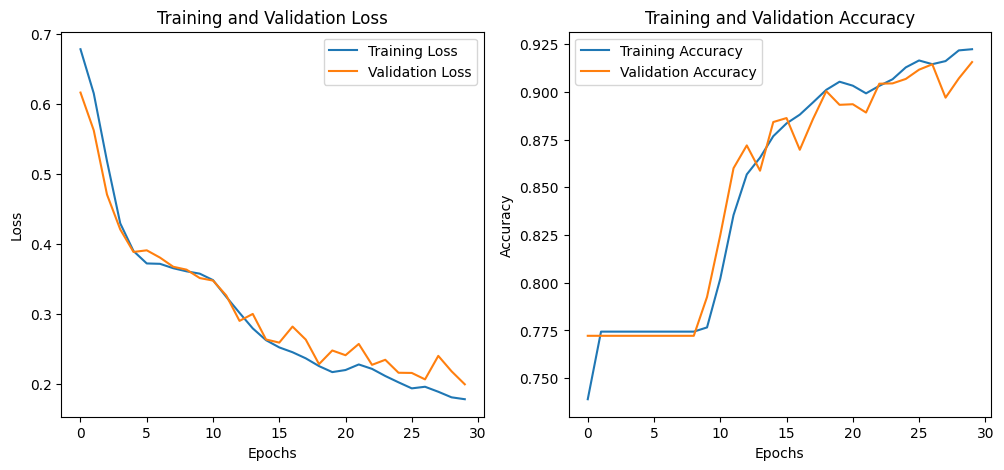

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History

# 假设你已经定义好了 unet_model 函数
unet = unet_model()
unet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型并保存训练历史
history = unet.fit(X_train, y_train, batch_size=1, epochs=30, validation_split=0.1)

# 绘制训练曲线
def plot_training_history(history):
    # 绘制训练和验证损失
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制训练和验证准确率
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 调用函数绘制训练曲线
plot_training_history(history)


1/1 [==============================] - 4s 4s/step


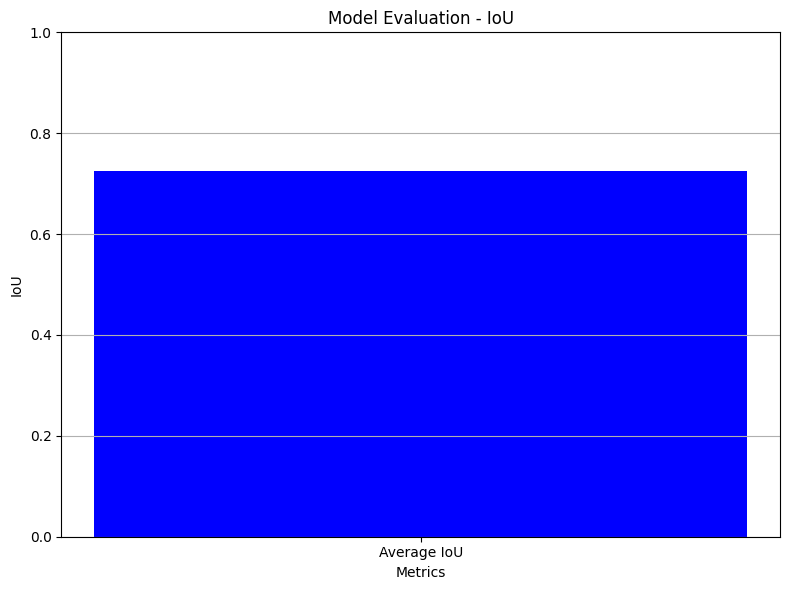

Average IoU: 0.7252242152059851


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 计算 IoU
iou_scores = []  # 存储每个样本的 IoU 分数
for i in range(len(X_test)):
    y_true = (y_test[i] > 0.5).astype(int)
    y_pred = (unet.predict(X_test[i:i+1]) > 0.5).astype(int)
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_true, y_pred))
    iou = intersection / (union + 1e-6)  # 加上一个小的常数避免分母为零
    iou_scores.append(iou)

# 计算平均 IoU
average_iou = np.mean(iou_scores)

# 创建图表并添加数据
plt.figure(figsize=(8, 6))
plt.bar(['Average IoU'], [average_iou], color='blue')
plt.ylim(0, 1)  # 设置 y 轴范围从 0 到 1
plt.title('Model Evaluation - IoU')
plt.xlabel('Metrics')
plt.ylabel('IoU')
plt.grid(axis='y')  # 显示 y 轴网格线
plt.tight_layout()  # 调整布局使得标签不重叠

# 显示图表
plt.show()

print(f'Average IoU: {average_iou}')

In [ ]:
test_loss, test_acc = unet.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

1/1 [==============================] - 2s 2s/step - loss: 0.1828 - accuracy: 0.9252
Test accuracy: 0.925201416015625


# Predictions and Further Analysis:

In [ ]:
predictions_unet = unet.predict(X_test)
# Post-process and visualize predictions...

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


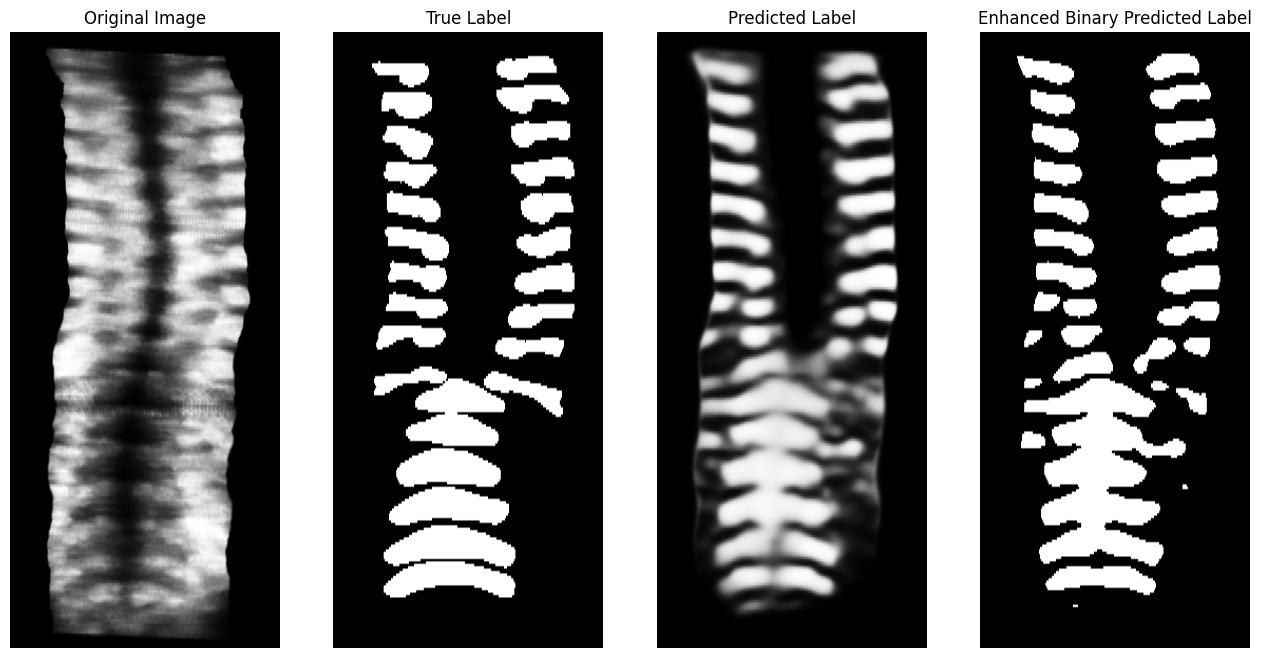

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance

# 首先获取模型的预测结果
predictions = unet.predict(X_test)

# 确保 n_samples 不大于 X_test 的长度
n_samples = min(5, len(X_test))

print_plot(n_samples,X_test,y_test,predictions_unet)

# **Advanced U-Net**

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

def load_data(image_dir, label_dir):
    image_files = []
    label_files = []

    # Get the list of BMP format image files
    for file in os.listdir(image_dir):
        if file.endswith('.bmp'):
            image_files.append(os.path.join(image_dir, file))

    # Get the list of PNG format image files
    for file in os.listdir(label_dir):
        if file.endswith('.png'):
            label_files.append(os.path.join(label_dir, file))

    image_files = sorted(image_files)
    label_files = sorted(label_files)

    images = []
    labels = []

    # Load and preprocess image data
    for img_file, lbl_file in zip(image_files, label_files):
        img = Image.open(img_file).convert('RGB')
        lbl = Image.open(lbl_file).convert('L')

        # Check image size compatibility
        if img.size == lbl.size:
            images.append(np.array(img))
            lbl = np.array(lbl)
            lbl = np.expand_dims(lbl, axis=-1)
            lbl[lbl > 0] = 1  # Binarize the label
            labels.append(lbl)
        else:
            print(f"Image and label size mismatch for files: {img_file}, {lbl_file}")

    images = np.array(images, dtype=object)  # Use object dtype to handle variable-sized images
    labels = np.array(labels, dtype=object)

    return images, labels

# Define dataset paths
image_dir = '/content/drive/MyDrive/image_10'
label_dir = '/content/drive/MyDrive/image_10_label'

if os.path.isdir(image_dir) and os.path.isdir(label_dir):
    images, labels = load_data(image_dir, label_dir)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

    # Proceed with model training and other steps as needed
else:
    print("Please provide valid image and label directory paths.")


In [ ]:
from scipy.ndimage import zoom
import numpy as np
from PIL import Image, ImageOps

# 假设 img_pred 是一张二维灰度图像（numpy 数组格式）
img_pred = np.random.rand(100, 100)  # 假设图像大小为 100x100
zoom_factors = (1, 1)  # 缩放因子，对应水平和垂直方向上的缩放比例，设置为 (1, 1) 保持原始尺寸

# 检查输入图像的维度，并根据维度设置缩放因子
if len(img_pred.shape) == 2:
    zoomed_img_pred = zoom(img_pred, zoom_factors, order=1, mode='nearest')
    # Convert the grayscale image to RGB by duplicating the single channel into three channels
    rgb_img_pred = ImageOps.grayscale(Image.fromarray(np.uint8(zoomed_img_pred * 255))).convert('RGB')
elif len(img_pred.shape) == 3:
    zoom_factors = zoom_factors + (1,)  # 在通道维度上不进行缩放
    zoomed_img_pred = zoom(img_pred, zoom_factors, order=1, mode='nearest')
    rgb_img_pred = Image.fromarray(np.uint8(zoomed_img_pred * 255)).convert('RGB')
else:
    raise ValueError("Input image should be 2D (grayscale) or 3D (RGB)")

# 可以继续对 rgb_img_pred 进行后续的图像处理操作，如保存图像、显示图像等
rgb_img_pred.save('processed_image.png')
rgb_img_pred.show()


# **An advanced/enhanced of the U-Net model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def residual_block(input_tensor, num_filters):
    residual = Conv2D(num_filters, (1, 1), strides=(1, 1), padding='same')(input_tensor)
    residual = BatchNormalization()(residual)

    x = conv_block(input_tensor, num_filters)
    x = tf.add(x, residual)
    return x

def build_advanced_unet(input_shape=(256, 256, 3), num_classes=1):  # 修改输入尺寸为(256, 256, 3)
    inputs = Input(input_shape)

    # Encoder
    x1 = residual_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(x1)

    x2 = residual_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(x2)

    x3 = residual_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(x3)

    x4 = residual_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(x4)

    # Bridge
    b = conv_block(p4, 1024)

    # Decoder
    u1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(b)
    u1 = concatenate([u1, x4])
    x5 = conv_block(u1, 512)

    u2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x5)
    u2 = concatenate([u2, x3])
    x6 = conv_block(u2, 256)

    u3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x6)
    u3 = concatenate([u3, x2])
    x7 = conv_block(u3, 128)

    u4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x7)
    u4 = concatenate([u4, x1])
    x8 = conv_block(u4, 64)

    # Output
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(x8)

    A_Unet = Model(inputs=inputs, outputs=output)
    return A_Unet

# Example usage
input_shape = (256, 256, 3)  # 修改输入尺寸为(256, 256, 3)
A_Unet = build_advanced_unet(input_shape)
A_Unet.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_96 (Conv2D)          (None, 256, 256, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 256, 256, 64)         256       ['conv2d_96[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization_1[

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_data111(image_dir, label_dir, target_size=(256, 256)):
    image_files = []
    label_files = []

    # Get the list of BMP format image files
    for file in os.listdir(image_dir):
        if file.endswith('.bmp'):
            image_files.append(os.path.join(image_dir, file))

    # Get the list of PNG format image files
    for file in os.listdir(label_dir):
        if file.endswith('.png'):
            label_files.append(os.path.join(label_dir, file))

    image_files = sorted(image_files)
    label_files = sorted(label_files)

    images = []
    labels = []

    # Load and preprocess image data
    for img_file, lbl_file in zip(image_files, label_files):
        img = Image.open(img_file).convert('RGB')
        lbl = Image.open(lbl_file).convert('L')

        # Resize images and labels to target size
        img = img.resize(target_size)
        lbl = lbl.resize(target_size)

        # Convert images and labels to NumPy arrays
        images.append(np.array(img, dtype=np.float32))  # Convert image to float32
        lbl = np.array(lbl, dtype=np.float32) / 255.0  # Convert label to float32 and normalize
        lbl = np.expand_dims(lbl, axis=-1)
        lbl[lbl > 0] = 1  # Binarize the label
        labels.append(lbl)

    images = np.array(images)  # Convert to NumPy array
    labels = np.array(labels)

    return images, labels

# Define dataset paths
image_dir = '/content/drive/MyDrive/image_10'
label_dir = '/content/drive/MyDrive/image_10_label'

if os.path.isdir(image_dir) and os.path.isdir(label_dir):
    images, labels = load_data111(image_dir, label_dir)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

    # Convert NumPy arrays to TensorFlow tensors with appropriate shapes
    X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
    X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

    # Check the shapes of the tensors
    print("X_train_tensor shape:", X_train_tensor.shape)
    print("y_train_tensor shape:", y_train_tensor.shape)
    print("X_test_tensor shape:", X_test_tensor.shape)
    print("y_test_tensor shape:", y_test_tensor.shape)

    # Proceed with model training and other steps as needed
else:
    print("Please provide valid image and label directory paths.")


X_train_tensor shape: (9, 256, 256, 3)
y_train_tensor shape: (9, 256, 256, 1)
X_test_tensor shape: (1, 256, 256, 3)
y_test_tensor shape: (1, 256, 256, 1)


In [ ]:
from tensorflow.keras.optimizers import Adam

A_Unet.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# 模型训练
history = A_Unet.fit(X_train_tensor, y_train_tensor, batch_size=1, epochs=30, validation_split=0.1)

# 模型评估
test_loss, test_accuracy = A_Unet.evaluate(X_test_tensor, y_test_tensor)


Epoch 1/30
8/8 [==============================] - 107s 11s/step - loss: 0.7677 - accuracy: 0.5971 - val_loss: 0.8880 - val_accuracy: 0.5842
Epoch 2/30
8/8 [==============================] - 85s 11s/step - loss: 0.7125 - accuracy: 0.6495 - val_loss: 0.7076 - val_accuracy: 0.6624
Epoch 3/30
8/8 [==============================] - 81s 10s/step - loss: 0.6736 - accuracy: 0.6760 - val_loss: 0.6467 - val_accuracy: 0.7177
Epoch 4/30
8/8 [==============================] - 82s 11s/step - loss: 0.6432 - accuracy: 0.6919 - val_loss: 0.6203 - val_accuracy: 0.7391
Epoch 5/30
8/8 [==============================] - 84s 11s/step - loss: 0.6187 - accuracy: 0.7025 - val_loss: 0.6015 - val_accuracy: 0.7531
Epoch 6/30
8/8 [==============================] - 83s 11s/step - loss: 0.5964 - accuracy: 0.7132 - val_loss: 0.5900 - val_accuracy: 0.7571
Epoch 7/30
8/8 [==============================] - 84s 11s/step - loss: 0.5756 - accuracy: 0.7239 - val_loss: 0.5789 - val_accuracy: 0.7624
Epoch 8/30
8/8 [==========

Test loss: 0.3849986493587494
Test accuracy: 0.8572540283203125


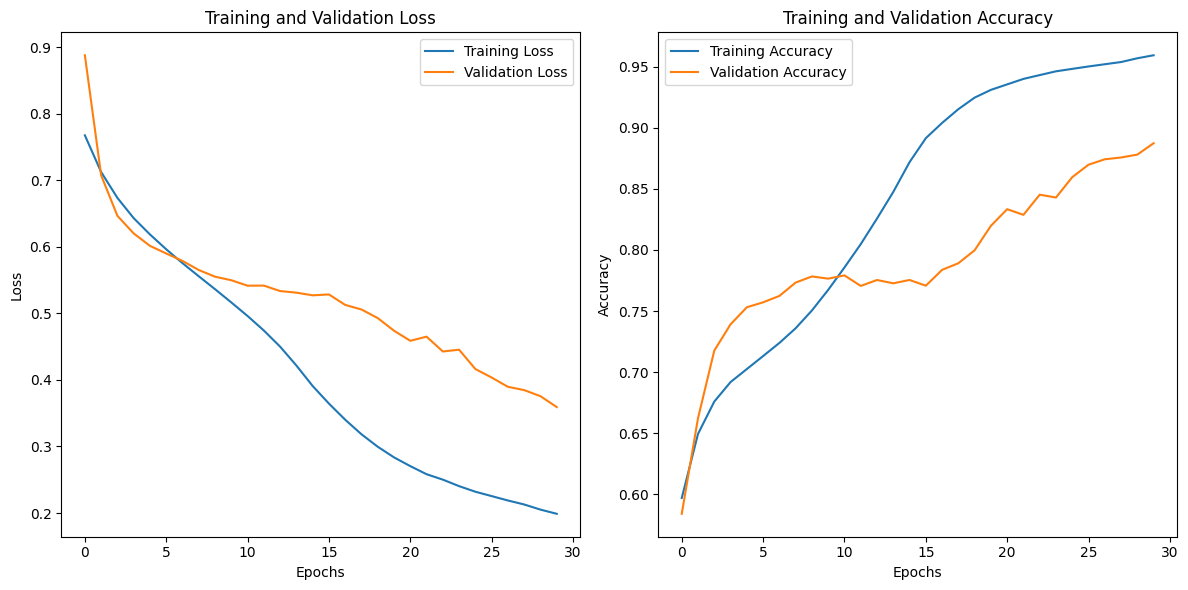

In [ ]:
import matplotlib.pyplot as plt

# 输出测试集的损失和准确率
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

# 绘制训练过程中的损失和准确率曲线
plt.figure(figsize=(12, 6))

# 绘制训练集和验证集的损失曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 绘制训练集和验证集的准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
predictions_A_Unet = A_Unet.predict(X_test_tensor)

1/1 [==============================] - 2s 2s/step


In [ ]:
print(predictions_A_Unet)

[[[[0.6399258 ]
   [0.492427  ]
   [0.49143904]
   ...
   [0.43474323]
   [0.36699033]
   [0.43078515]]

  [[0.45819688]
   [0.41909787]
   [0.33730856]
   ...
   [0.39158082]
   [0.30593675]
   [0.5536203 ]]

  [[0.41214404]
   [0.33060002]
   [0.21790549]
   ...
   [0.20287888]
   [0.26418576]
   [0.3961696 ]]

  ...

  [[0.35525984]
   [0.27644214]
   [0.19888775]
   ...
   [0.18015046]
   [0.29951933]
   [0.41617045]]

  [[0.33459705]
   [0.4050826 ]
   [0.28537118]
   ...
   [0.34687576]
   [0.40407673]
   [0.46077928]]

  [[0.4228773 ]
   [0.4199917 ]
   [0.31327626]
   ...
   [0.33254963]
   [0.39206946]
   [0.45631957]]]]


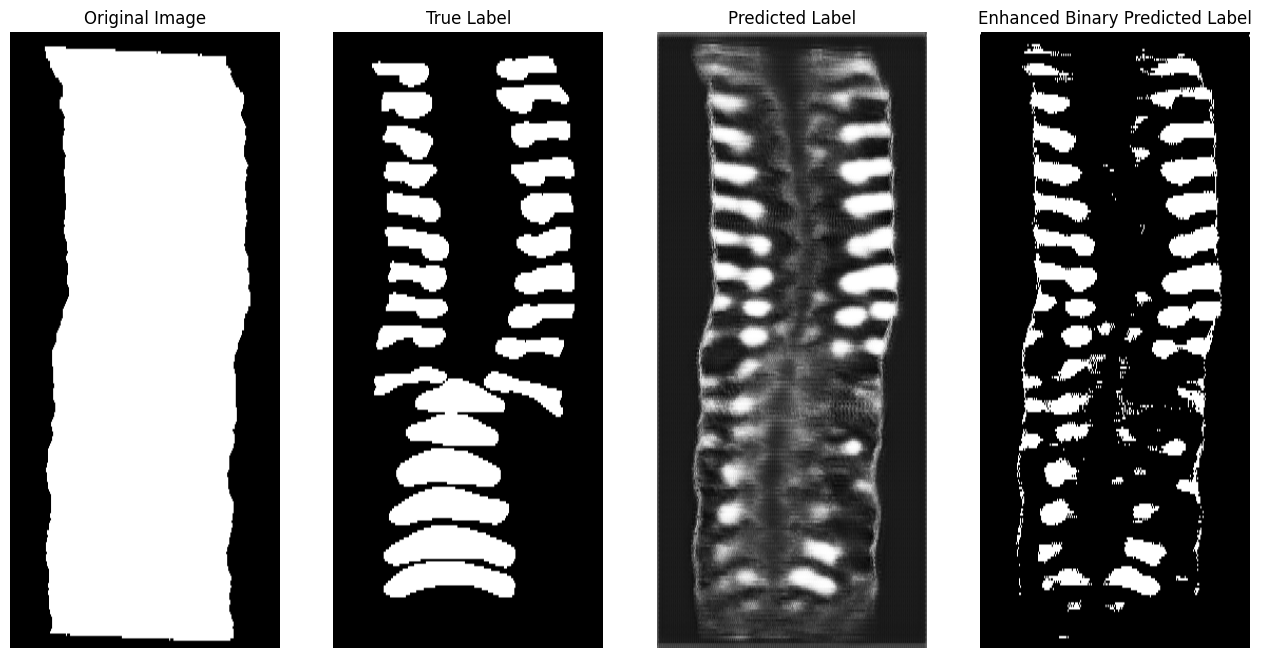

In [ ]:
import numpy as np
from PIL import Image, ImageEnhance


def print_plot(n_sample, X_test_tensor, y_test_tensor, predictions_A_Unet):
    for i in range(n_sample):
        plt.figure(figsize=(16, 8))

        # 显示原始图像
        plt.subplot(1, 4, 1)
        plt.imshow(X_test_tensor[i], cmap='gray', aspect='auto')
        plt.title('Original Image')
        plt.axis('off')

        # 显示真实的标签
        plt.subplot(1, 4, 2)
        plt.imshow(np.squeeze(y_test_tensor[i]), cmap='gray', aspect='auto')  # 使用np.squeeze()处理张量
        plt.title('True Label')
        plt.axis('off')

        # 显示模型的预测结果
        plt.subplot(1, 4, 3)
        plt.imshow(np.squeeze(predictions_A_Unet[i]), cmap='gray', aspect='auto')  # 使用np.squeeze()处理张量
        plt.title('Predicted Label')
        plt.axis('off')

        # 合并预测图像和增强，二值化并显示
        plt.subplot(1, 4, 4)
        threshold = 0.5
        pred_img_binary = np.where(np.squeeze(predictions_A_Unet[i]) > threshold, 0, 1)
        enhanced_pred_img = Image.fromarray(pred_img_binary.astype(np.uint8) * 255)
        contrast_enhancer = ImageEnhance.Contrast(enhanced_pred_img)
        enhanced_img = contrast_enhancer.enhance(1.0)
        plt.imshow(np.asarray(enhanced_img), cmap='binary', aspect='auto')
        plt.title('Enhanced Binary Predicted Label')
        plt.axis('off')

        plt.show()

# 在模型评估后调用可视化函数
print_plot(X_test_tensor.shape[0], X_test_tensor.numpy(), y_test_tensor.numpy(), predictions_A_Unet)


# **FCN**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate

def fcn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D((2, 2))(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, (3, 3), strides=(2, 2), activation='relu', padding='same')(pool5)
    merge6 = Concatenate()([up6, conv5])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv6)
    merge7 = Concatenate()([up7, conv4])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv7)
    merge8 = Concatenate()([up8, conv3])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv8)
    merge9 = Concatenate()([up9, conv2])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    up10 = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv9)
    merge10 = Concatenate()([up10, conv1])
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge10)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10)

    output = Conv2D(1, (1, 1), activation='sigmoid')(conv10)  # 修改为sigmoid激活函数，输出通道数为1

    fcn_model = Model(inputs=inputs, outputs=output)
    return fcn_model

# 使用示例
input_shape = (256, 256, 3)
num_classes = 1  # 输出通道数修改为1
fcn_model = fcn_model(input_shape, num_classes)
fcn_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_61 (Conv2D)          (None, 256, 256, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 conv2d_62 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_61[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 128, 128, 64)         0         ['conv2d_62[0][0]']           
 ng2D)                                                                                      

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy

fcn_model.compile(optimizer='adam',
              loss=BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

In [ ]:
def load_data(image_dir, label_dir, target_size=(256, 256)):
    image_files = []
    label_files = []

    # Get the list of image files
    for file in os.listdir(image_dir):
        if file.endswith('.bmp'):
            image_files.append(os.path.join(image_dir, file))

    for file in os.listdir(label_dir):
        if file.endswith('.png'):
            label_files.append(os.path.join(label_dir, file))

    image_files = sorted(image_files)
    label_files = sorted(label_files)

    images = []
    labels = []

    # Load and preprocess image data
    for img_file, lbl_file in zip(image_files, label_files):
        img = Image.open(img_file).convert('RGB').resize(target_size)
        lbl = Image.open(lbl_file).convert('L').resize(target_size)

        img = np.array(img)
        lbl = np.array(lbl)
        lbl = np.expand_dims(lbl, axis=-1)  # Add channel dimension
        lbl[lbl > 0] = 1  # Binarize the label

        images.append(img)
        labels.append(lbl)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

#使用新的 load_data 函数，包括 target_size 参数
images, labels = load_data(image_dir, label_dir)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

In [ ]:
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
fcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# 训练模型
history = fcn_model.fit(X_train, y_train, batch_size=2, epochs=30, validation_split=0.1)

Epoch 1/30
4/4 [==============================] - 49s 10s/step - loss: 123.5239 - accuracy: 0.6210 - val_loss: 2.9790 - val_accuracy: 0.7720
Epoch 2/30
4/4 [==============================] - 40s 9s/step - loss: 1.6988 - accuracy: 0.7714 - val_loss: 0.6489 - val_accuracy: 0.7839
Epoch 3/30
4/4 [==============================] - 42s 10s/step - loss: 0.6955 - accuracy: 0.7014 - val_loss: 0.7245 - val_accuracy: 0.6314
Epoch 4/30
4/4 [==============================] - 37s 9s/step - loss: 0.7046 - accuracy: 0.6652 - val_loss: 0.6784 - val_accuracy: 0.7116
Epoch 5/30
4/4 [==============================] - 40s 10s/step - loss: 0.6685 - accuracy: 0.7554 - val_loss: 0.6464 - val_accuracy: 0.7844
Epoch 6/30
4/4 [==============================] - 38s 9s/step - loss: 0.6431 - accuracy: 0.7955 - val_loss: 0.6232 - val_accuracy: 0.7894
Epoch 7/30
4/4 [==============================] - 41s 10s/step - loss: 0.6325 - accuracy: 0.7942 - val_loss: 0.6120 - val_accuracy: 0.8022
Epoch 8/30
4/4 [============

In [ ]:
import torch

# 计算Dice系数
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.item()  # 返回Dice系数的值

# 将测试数据输入模型进行推理得到预测结果
y_pred = A_Unet.predict(X_test_tensor)

# 将预测结果和真实标签转换为PyTorch张量
y_pred_tensor = torch.tensor(y_pred)
y_test_tensor = torch.tensor(y_test_tensor)

# 计算Dice系数
dice = dice_coefficient(y_test_tensor, y_pred_tensor)
print(f"Dice Coefficient: {dice:.4f}")


NameError: name 'A_Unet' is not defined

In [ ]:
predictions_fcn = fcn_model.predict(X_test)
# Post-process and visualize predictions...

1/1 [==============================] - 4s 4s/step


In [ ]:
loss, accuracy = fcn_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


1/1 [==============================] - 2s 2s/step - loss: 0.3067 - accuracy: 0.8544
Test Loss: 0.3067258596420288
Test Accuracy: 0.8543853759765625


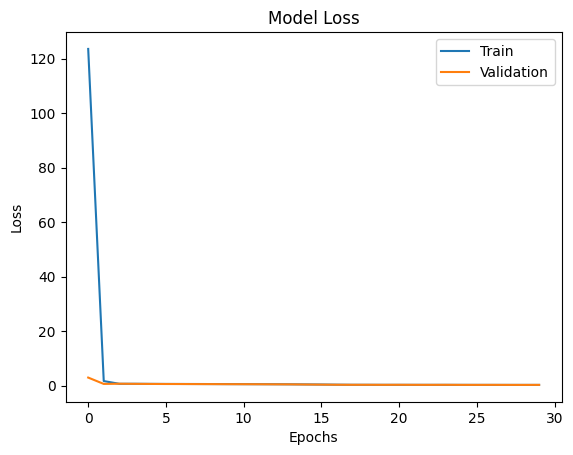

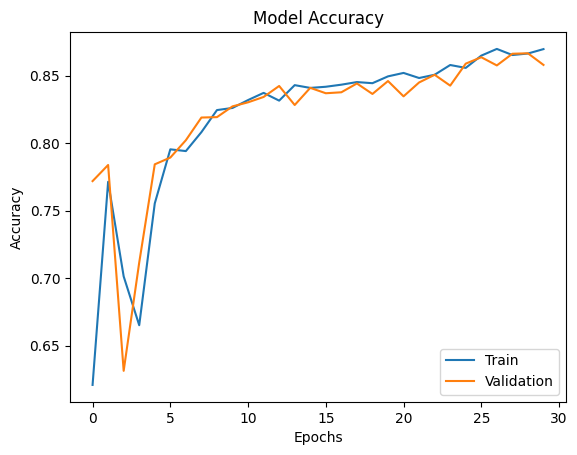

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

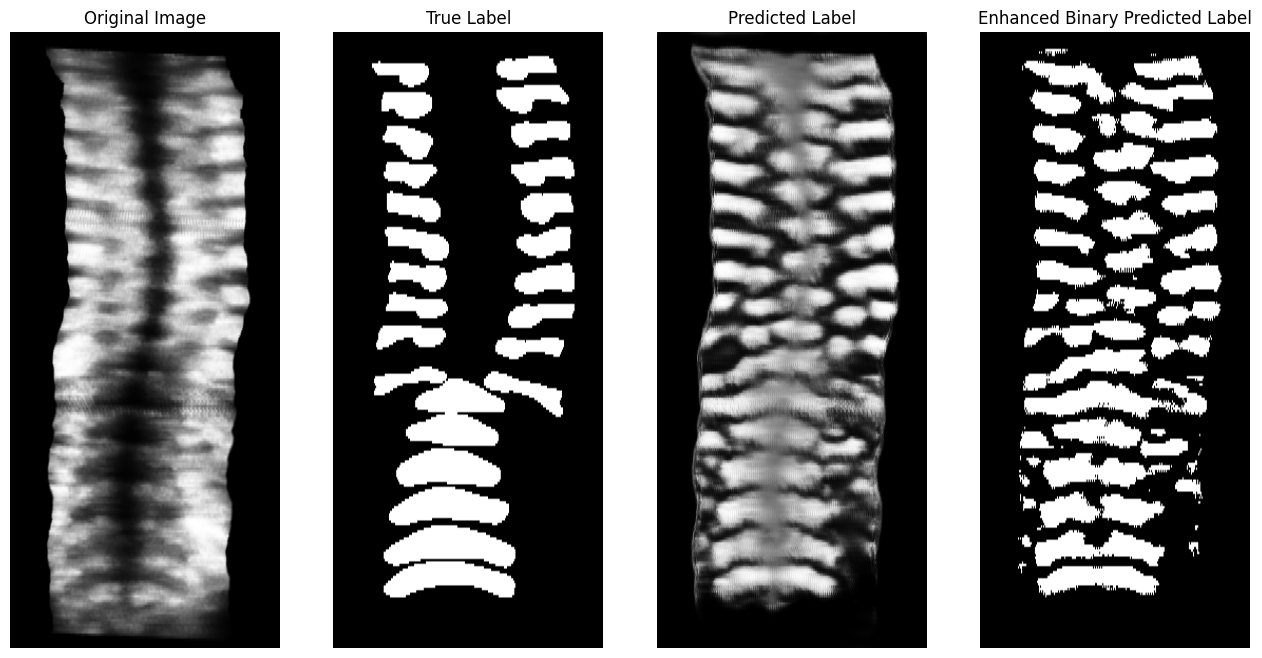

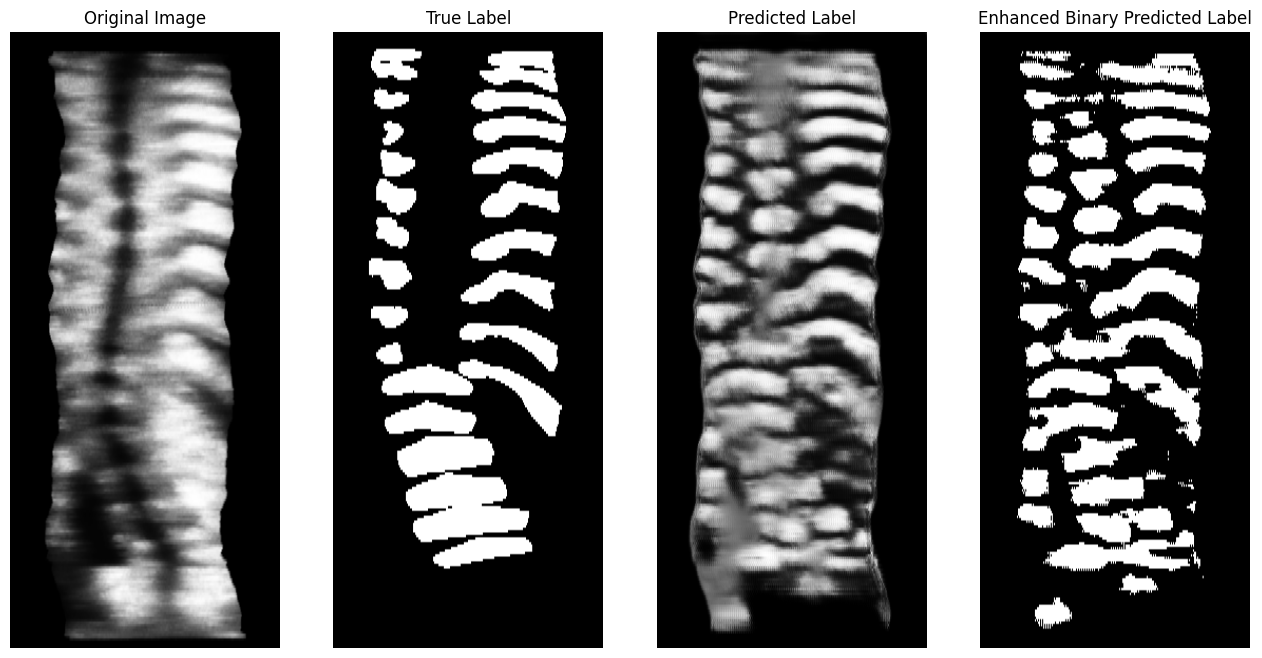

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

def print_plot(num_samples, X_test, y_test, predictions_fcn):
    for i in range(num_samples):
        plt.figure(figsize=(16, 8))

        # 显示原始图像
        plt.subplot(1, 4, 1)
        plt.imshow(X_test[i], cmap='gray', aspect='auto')
        plt.title('Original Image')
        plt.axis('off')

        # 显示真实的标签
        plt.subplot(1, 4, 2)
        plt.imshow(np.squeeze(y_test[i]), cmap='gray', aspect='auto')  # 使用np.squeeze()处理张量
        plt.title('True Label')
        plt.axis('off')

        # 显示模型的预测结果
        plt.subplot(1, 4, 3)
        plt.imshow(np.squeeze(predictions_fcn[i]), cmap='gray', aspect='auto')  # 使用np.squeeze()处理张量
        plt.title('Predicted Label')
        plt.axis('off')

        # 合并预测图像和增强，二值化并显示
        plt.subplot(1, 4, 4)
        threshold = 0.5
        pred_img_binary = np.where(np.squeeze(predictions_fcn[i]) > threshold, 0, 1)
        enhanced_pred_img = Image.fromarray(pred_img_binary.astype(np.uint8) * 255)
        contrast_enhancer = ImageEnhance.Contrast(enhanced_pred_img)
        enhanced_img = contrast_enhancer.enhance(1.0)
        plt.imshow(np.asarray(enhanced_img), cmap='binary', aspect='auto')
        plt.title('Enhanced Binary Predicted Label')
        plt.axis('off')

        plt.show()

# 在模型评估后调用可视化函数
num_samples = X_test.shape[0]  # 测试样本数量
print_plot(num_samples, X_test, y_test, predictions_fcn)

# **Attention U-Net**

# Data Loading and Preprocessing for Attention UNet Model

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom
from PIL import ImageOps, ImageEnhance

def load_data(image_dir, label_dir, target_size):
    image_files = []
    label_files = []

    # Get the list of BMP format image files
    for file in os.listdir(image_dir):
        if file.endswith('.bmp'):
            image_files.append(os.path.join(image_dir, file))

    # Get the list of PNG format image files
    for file in os.listdir(label_dir):
        if file.endswith('.png'):
            label_files.append(os.path.join(label_dir, file))

    image_files = sorted(image_files)
    label_files = sorted(label_files)

    images = []
    labels = []

    # Load and preprocess image data
    for img_file, lbl_file in zip(image_files, label_files):
        img = Image.open(img_file).convert('RGB')
        lbl = Image.open(lbl_file).convert('L')

        # Resize images and labels to target size
        img = img.resize(target_size)
        lbl = lbl.resize(target_size)

        images.append(np.array(img, dtype=np.float32) / 255.0)  # Normalize image
        lbl = np.array(lbl)
        lbl = np.expand_dims(lbl, axis=-1)
        lbl[lbl > 0] = 1  # Binarize the label
        labels.append(lbl)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Define dataset paths and target size
image_dir = '/content/drive/MyDrive/image_10'
label_dir = '/content/drive/MyDrive/image_10_label'
target_size = (256, 256)  # Set the target size for images and labels

if os.path.isdir(image_dir) and os.path.isdir(label_dir):
    images, labels = load_data(image_dir, label_dir, target_size)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

    # Proceed with model training and other steps as needed
else:
    print("Please provide valid image and label directory paths.")


# Attention UNet Model

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Activation, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.activations import sigmoid
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

def attention_gate(input_x, g, inter_channel):
    # inter_channel represents the internal channel size of the attention gate, usually set to half of the input_x channels
    theta_x = Conv2D(inter_channel, kernel_size=2, strides=2, padding='same')(input_x)
    phi_g = Conv2D(inter_channel, kernel_size=1, padding='same')(g)

    concat_xg = Activation('relu')(tf.keras.layers.add([theta_x, phi_g]))
    psi = Conv2D(1, kernel_size=1, padding='same')(concat_xg)
    psi = sigmoid(psi)

    upsample_psi = UpSampling2D(size=(2, 2))(psi)
    return Multiply()([input_x, upsample_psi])

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    return x

def build_attention_unet(input_shape, num_classes=1):
    inputs = Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bridge
    c4 = conv_block(p3, 512)

    # Decoder with attention gates
    ag1 = attention_gate(c3, c4, 128)
    u1 = UpSampling2D((2, 2))(c4)
    u1 = Concatenate()([u1, ag1])
    c5 = conv_block(u1, 256)

    ag2 = attention_gate(c2, c5, 64)
    u2 = UpSampling2D((2, 2))(c5)
    u2 = Concatenate()([u2, ag2])
    c6 = conv_block(u2, 128)

    ag3 = attention_gate(c1, c6, 32)
    u3 = UpSampling2D((2, 2))(c6)
    u3 = Concatenate()([u3, ag3])
    c7 = conv_block(u3, 64)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c7)

    attention_unet = Model(inputs=[inputs], outputs=[outputs])
    return attention_unet

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# 定义模型超参数
input_shape = (256, 256, 3)
num_classes = 1
learning_rate = 0.001
epochs = 20
batch_size = 32

# 构建模型
attention_unet = build_attention_unet(input_shape, num_classes)

# 编译模型
optimizer = Adam(learning_rate=learning_rate)
loss_function = BinaryCrossentropy()
attention_unet.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# 模型概要
attention_unet.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_118 (Conv2D)         (None, 256, 256, 64)         1792      ['input_7[0][0]']             
                                                                                                  
 activation_18 (Activation)  (None, 256, 256, 64)         0         ['conv2d_118[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)         (None, 256, 256, 64)         36928     ['activation_18[0][0]']       
                                                                                            

# Model Training and Evaluation

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# 定义训练参数
epochs = 30
batch_size = 1
learning_rate = 0.0001

# 编译模型
optimizer = Adam(learning_rate=learning_rate)
loss_function = BinaryCrossentropy()
attention_unet.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# 训练模型
history_attention_unet = attention_unet.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# 模型评估
test_loss, test_accuracy = attention_unet.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/30
9/9 [==============================] - 74s 8s/step - loss: 0.6824 - accuracy: 0.7652 - val_loss: 0.6439 - val_accuracy: 0.7589
Epoch 2/30
9/9 [==============================] - 71s 8s/step - loss: 0.6279 - accuracy: 0.7741 - val_loss: 0.5637 - val_accuracy: 0.7589
Epoch 3/30
9/9 [==============================] - 67s 7s/step - loss: 0.4806 - accuracy: 0.7741 - val_loss: 0.4507 - val_accuracy: 0.7589
Epoch 4/30
9/9 [==============================] - 71s 8s/step - loss: 0.4076 - accuracy: 0.7741 - val_loss: 0.4193 - val_accuracy: 0.7589
Epoch 5/30
9/9 [==============================] - 68s 8s/step - loss: 0.3844 - accuracy: 0.7741 - val_loss: 0.4019 - val_accuracy: 0.7589
Epoch 6/30
9/9 [==============================] - 68s 8s/step - loss: 0.3719 - accuracy: 0.7741 - val_loss: 0.3869 - val_accuracy: 0.7589
Epoch 7/30
9/9 [==============================] - 71s 8s/step - loss: 0.3639 - accuracy: 0.7741 - val_loss: 0.3782 - val_accuracy: 0.7589
Epoch 8/30
9/9 [==================

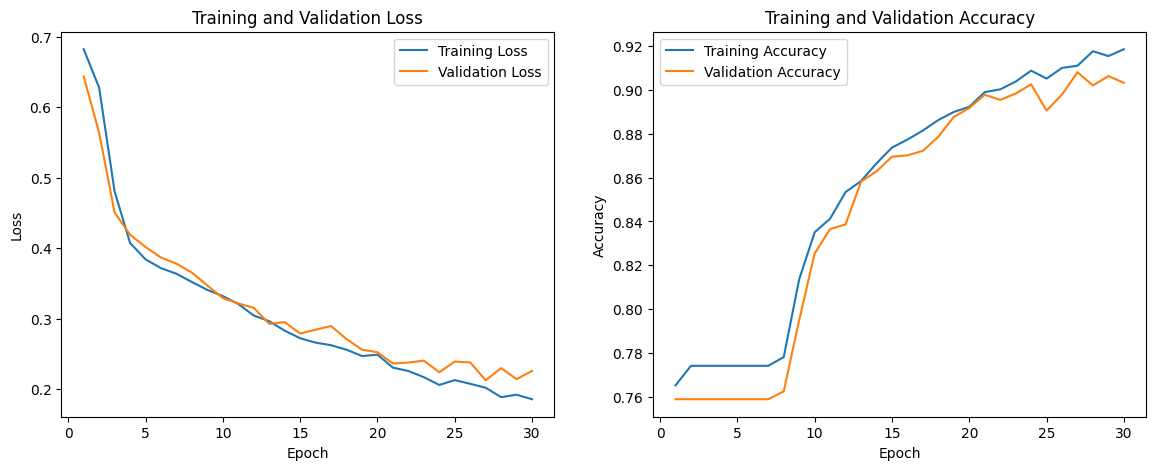

In [ ]:
import matplotlib.pyplot as plt

# 提取训练历史中的损失和准确率
train_loss = history_attention_unet.history['loss']
val_loss = history_attention_unet.history['val_loss']
train_accuracy = history_attention_unet.history['accuracy']
val_accuracy = history_attention_unet.history['val_accuracy']

# 设置绘图
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 5))

# 绘制损失曲线
plt.subplot(1, 2, 1)  # 1行2列的第一个
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)  # 1行2列的第二个
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# 模型评估
test_loss, test_accuracy = attention_unet.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 [==============================] - 1s 1s/step - loss: 0.2261 - accuracy: 0.9033
Test Loss: 0.22608047723770142
Test Accuracy: 0.903289794921875


1/1 [==============================] - 2s 2s/step - loss: 0.2261 - accuracy: 0.9033


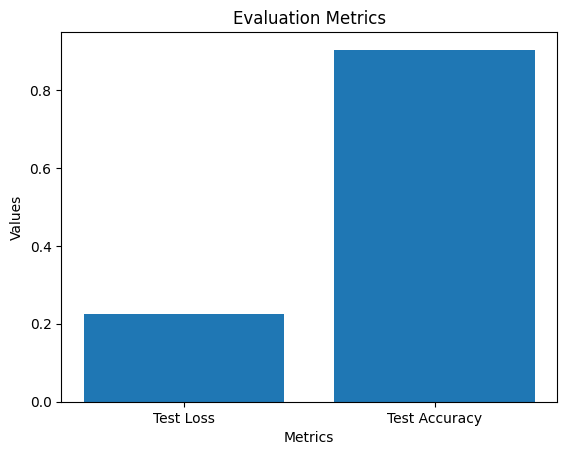

In [ ]:
import matplotlib.pyplot as plt

# 模型评估
test_loss, test_accuracy = attention_unet.evaluate(X_test, y_test)

# 可视化评估结果
labels = ['Test Loss', 'Test Accuracy']
values = [test_loss, test_accuracy]

plt.bar(labels, values)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics')
plt.show()


In [ ]:
from tqdm import tqdm

# 模型评估
test_loss, test_accuracy = attention_unet.evaluate(X_test, y_test)

# 可视化评估结果
with tqdm(total=100) as pbar:
    pbar.set_description('Test Accuracy')
    pbar.update(test_accuracy * 100)


1/1 [==============================] - 2s 2s/step - loss: 0.2261 - accuracy: 0.9033


Test Accuracy:  90%|█████████ | 90.3289794921875/100 [00:00<00:00, 63134.01it/s]


# Data Loading and Preprocessing with Custom Target Size

In [ ]:
def load_data(image_dir, label_dir, target_size=(256, 256)):
    image_files = []
    label_files = []

    # Get the list of image files
    for file in os.listdir(image_dir):
        if file.endswith('.bmp'):
            image_files.append(os.path.join(image_dir, file))

    for file in os.listdir(label_dir):
        if file.endswith('.png'):
            label_files.append(os.path.join(label_dir, file))

    image_files = sorted(image_files)
    label_files = sorted(label_files)

    images = []
    labels = []

    # Load and preprocess image data
    for img_file, lbl_file in zip(image_files, label_files):
        img = Image.open(img_file).convert('RGB').resize(target_size)
        lbl = Image.open(lbl_file).convert('L').resize(target_size)

        img = np.array(img)
        lbl = np.array(lbl)
        lbl = np.expand_dims(lbl, axis=-1)  # Add channel dimension
        lbl[lbl > 0] = 1  # Binarize the label

        images.append(img)
        labels.append(lbl)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

#使用新的 load_data 函数，包括 target_size 参数
images, labels = load_data(image_dir, label_dir)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Prediction with Attention UNet Model

In [ ]:
predictions_attention_unet = attention_unet.predict(X_test)

1/1 [==============================] - 3s 3s/step


# Visualization of Predictions with Post-Processing

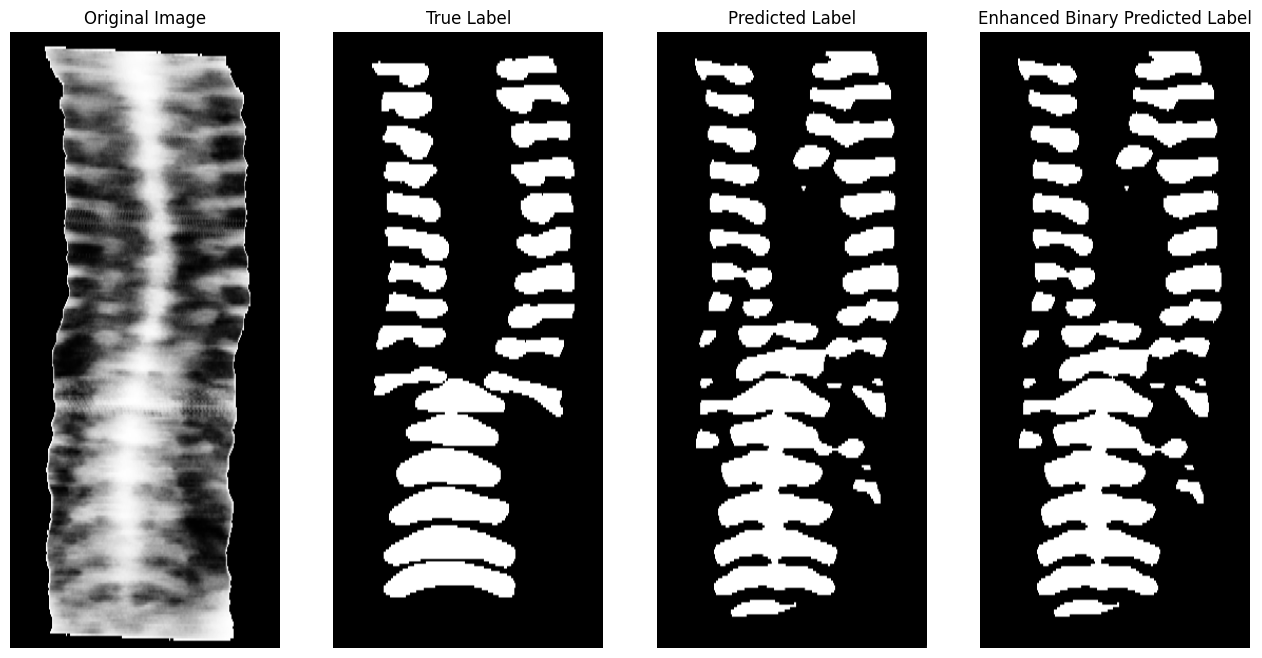

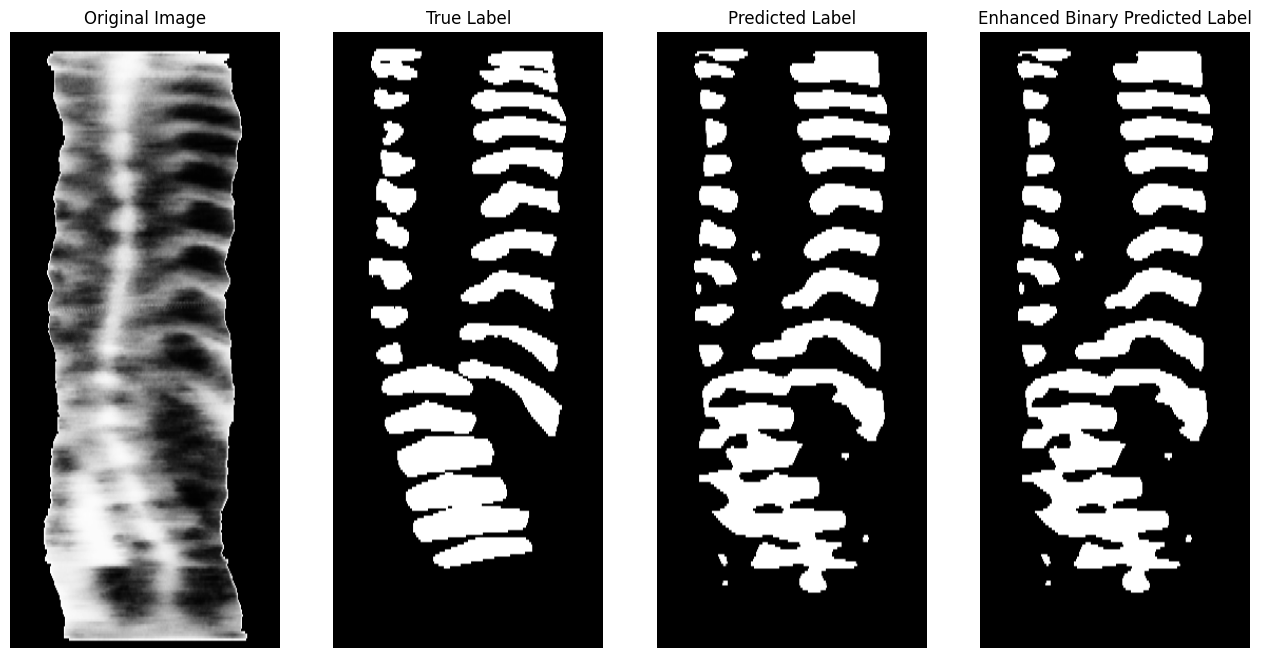

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

def visualize_predictions(num_samples, X_test, y_test, predictions_attention_unet):
    for i in range(num_samples):
        plt.figure(figsize=(16, 8))

        # Display the original image
        img_uint8 = (X_test[i, :, :, 0] * 255).astype(np.uint8)
        plt.subplot(1, 4, 1)
        plt.imshow(img_uint8, cmap='gray', aspect='auto', extent=[0, X_test.shape[2], 0, X_test.shape[1]])
        plt.title('Original Image')
        plt.axis('off')

        # Display the true label
        plt.subplot(1, 4, 2)
        plt.imshow(np.squeeze(y_test[i, :, :, 0]), cmap='gray', aspect='auto', extent=[0, y_test.shape[2], 0, y_test.shape[1]])
        plt.title('True Label')
        plt.axis('off')

        # Display the predicted label
        plt.subplot(1, 4, 3)
        plt.imshow(np.squeeze(predictions_attention_unet[i, :, :, 0]), cmap='gray', aspect='auto', extent=[0, predictions_attention_unet.shape[2], 0, predictions_attention_unet.shape[1]])
        plt.title('Predicted Label')
        plt.axis('off')

        # Post-process the predicted label and display
        plt.subplot(1, 4, 4)
        threshold = 0.5
        pred_img_binary = np.where(np.squeeze(predictions_attention_unet[i, :, :, 0]) > threshold, 0, 1)
        enhanced_pred_img = Image.fromarray(pred_img_binary.astype(np.uint8) * 255)
        contrast_enhancer = ImageEnhance.Contrast(enhanced_pred_img)
        enhanced_img = contrast_enhancer.enhance(1.0)
        plt.imshow(np.asarray(enhanced_img), cmap='binary', aspect='auto', extent=[0, enhanced_img.width, 0, enhanced_img.height])
        plt.title('Enhanced Binary Predicted Label')
        plt.axis('off')

        plt.show()

# Assuming predictions_attention_unet contains the predictions from model.predict(X_test)
visualize_predictions(X_test.shape[0], X_test, y_test, predictions_attention_unet)
